<a href="https://colab.research.google.com/github/SiddhiAsai/Advanced-Artificial-Intelligence/blob/main/AAI(Pracc9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] tiger: 0.9478


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


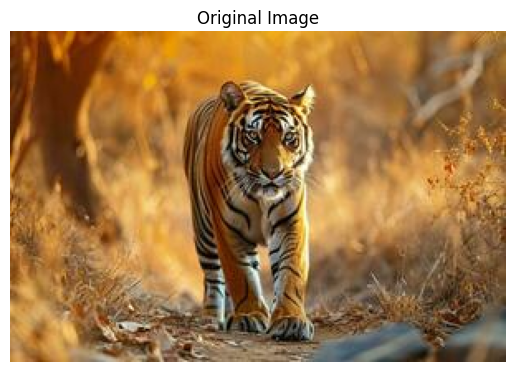

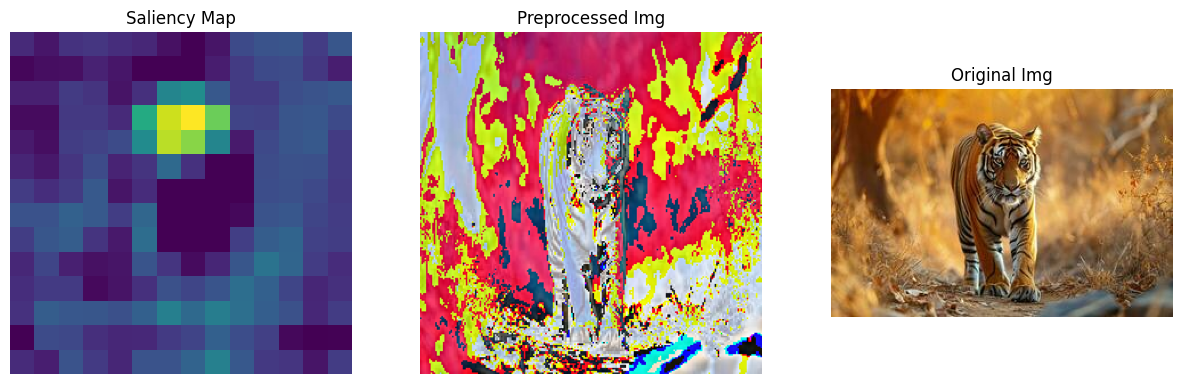

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import resnet50, VGG16, imagenet_utils

# Load pre-trained model
model = VGG16(weights="imagenet")

# Load and preprocess the image
img_path = '/content/AAI(8).jpg'
img = load_img(img_path)
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")

img = load_img('/content/AAI(8).jpg', target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = imagenet_utils.preprocess_input(img)

# Predict
preds = model.predict(img)
decoded = imagenet_utils.decode_predictions(preds, top=5)
(_, label, prob) = decoded[0][0]
print(f"[INFO] {label}: {prob:.4f}")

# Create a model that outputs the last conv layer and predictions
gradModel = Model(inputs=[model.inputs],
                  outputs=[model.get_layer("block5_conv3").output, model.output])

# Use gradient tape to capture gradients
with tf.GradientTape() as tape:
    inputs = tf.cast(img, tf.float32)

    (convOutputs, predictions) = gradModel(inputs)
    pred_index = tf.argmax(predictions[0])
    loss = predictions[:, pred_index]

    # compute gradients
    grads = tape.gradient(loss, convOutputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # compute saliency output
    convOutputs = convOutputs[0]
    last_conv_output = convOutputs @ pooled_grads[..., tf.newaxis]
    Saliency_Maps = tf.squeeze(last_conv_output)

    Saliency_Maps = tf.maximum(Saliency_Maps, 0) / tf.math.reduce_max(Saliency_Maps)
    Saliency_Maps = Saliency_Maps.numpy()

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Saliency Map")
plt.imshow(Saliency_Maps)
plt.axis("off")

plt.subplot(132)
plt.title("Preprocessed Img")
plt.imshow(img[0].astype('uint8'))
plt.axis("off")

plt.subplot(133)
plt.title("Original Img")
plt.imshow(load_img(img_path))
plt.axis("off")
plt.show()
